<a href="https://colab.research.google.com/github/abdul-rehaman-shaik/ML/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import joblib

# Load dataset only if not already loaded
if 'df' not in globals():
    df = pd.read_csv('/emp.csv')

# Quick sanity check
df.head()

# Encode categorical variables
df_encoded = df.copy()
label_encoders = {}
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Feature Engineering
df_encoded['Satisfaction_Score'] = (
    df_encoded['EnvironmentSatisfaction'] +
    df_encoded['JobSatisfaction'] +
    df_encoded['RelationshipSatisfaction'] +
    df_encoded['WorkLifeBalance']
) / 4

df_encoded['Experience_Ratio'] = df_encoded['YearsAtCompany'] / (df_encoded['TotalWorkingYears'] + 1)
df_encoded['Years_Since_Promotion'] = df_encoded['YearsAtCompany'] - df_encoded['YearsSinceLastPromotion']
df_encoded['Income_by_Age'] = df_encoded['MonthlyIncome'] / (df_encoded['Age'] + 1)
df_encoded['Work_Stress'] = df_encoded['OverTime'] * (1 - df_encoded['WorkLifeBalance'] / 4)
df_encoded['Job_Stability_Index'] = df_encoded['YearsInCurrentRole'] / (df_encoded['NumCompaniesWorked'] + 1)

df_encoded['Income_Percentile_by_Role'] = df_encoded.groupby('JobRole')['MonthlyIncome'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1)
)
df_encoded['Promotion_Velocity'] = df_encoded['YearsAtCompany'] / (df_encoded['YearsSinceLastPromotion'] + 1)
df_encoded['Training_per_Year'] = df_encoded['TrainingTimesLastYear'] / (df_encoded['TotalWorkingYears'] + 1)
df_encoded['Stock_Income_Ratio'] = df_encoded['StockOptionLevel'] / (df_encoded['MonthlyIncome'] / 10000 + 1)
df_encoded['Age_Experience_Gap'] = np.abs(df_encoded['Age'] - df_encoded['TotalWorkingYears'] - 18)
df_encoded['Department_Seniority'] = df_encoded.groupby('Department')['JobLevel'].transform('rank', pct=True)
df_encoded['Travel_Satisfaction_Impact'] = df_encoded['BusinessTravel'] * (1 - df_encoded['WorkLifeBalance'] / 4)
df_encoded['Overtime_Tenure_Ratio'] = df_encoded['OverTime'] / (df_encoded['YearsInCurrentRole'] + 1)
df_encoded['Career_Progression'] = (df_encoded['JobLevel'] / (df_encoded['YearsAtCompany'] + 1)) * 100
df_encoded['Comp_Satisfaction_Gap'] = (df_encoded['MonthlyIncome'] / 10000) - df_encoded['JobSatisfaction']

# Prepare features and target
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base models for stacking
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_base = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_base), ('rf', rf_base)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Train model
stacking_clf.fit(X_train_scaled, y_train)

# Save model
joblib.dump(stacking_clf, 'stacking_clf.pkl')
print("✅ Stacking model trained and saved as 'stacking_clf.pkl'")

# Predict attrition probability for all employees
X_full_scaled = scaler.transform(X)
attrition_probs = stacking_clf.predict_proba(X_full_scaled)[:, 1]
df_encoded['Attrition_Risk'] = attrition_probs

# Identify critical employees
def is_critical(row):
    return (
        (row['JobLevel'] >= 4) or
        (row['PerformanceRating'] >= 4) or
        (row['YearsAtCompany'] >= 10) or
        (row['Department'] in [
            label_encoders['Department'].transform(['Research & Development'])[0],
            label_encoders['Department'].transform(['Sales'])[0]
        ])
    )

df_encoded['Is_Critical'] = df_encoded.apply(is_critical, axis=1)

critical_employees = df_encoded[
    (df_encoded['Attrition_Risk'] > 0.6) &
    (df_encoded['Is_Critical'])
].copy()

# Generate retention suggestions
def retention_suggestion(row):
    suggestions = []
    if row['JobSatisfaction'] <= 2:
        suggestions.append("Assign mentorship, review job design")
    if row['MonthlyIncome'] < df_encoded['MonthlyIncome'].mean():
        suggestions.append("Review compensation, offer retention bonus")
    if row['YearsSinceLastPromotion'] > 3:
        suggestions.append("Consider career advancement plan")
    if row['OverTime'] == 1:
        suggestions.append("Offer flexible scheduling, workload relief")
    return "; ".join(suggestions) if suggestions else "Regular check-in"

critical_employees['Retention_Suggestion'] = critical_employees.apply(retention_suggestion, axis=1)

# Prepare final output
output_df = df_encoded.loc[
    critical_employees.index,
    ['EmployeeNumber', 'JobRole', 'Department', 'Attrition_Risk']
]
output_df['Retention_Suggestion'] = critical_employees['Retention_Suggestion']

# Convert encoded columns back to original labels
output_df['JobRole'] = label_encoders['JobRole'].inverse_transform(output_df['JobRole'])
output_df['Department'] = label_encoders['Department'].inverse_transform(output_df['Department'])

# Display critical employees with retention suggestions
print(output_df[['EmployeeNumber', 'JobRole', 'Department', 'Attrition_Risk', 'Retention_Suggestion']])

✅ Stacking model trained and saved as 'stacking_clf.pkl'
      EmployeeNumber                JobRole              Department  \
0                  1        Sales Executive                   Sales   
14                19  Laboratory Technician  Research & Development   
21                27   Sales Representative                   Sales   
26                33     Research Scientist  Research & Development   
33                42   Sales Representative                   Sales   
...              ...                    ...                     ...   
1396            1968        Sales Executive                   Sales   
1438            2023   Sales Representative                   Sales   
1444            2032  Laboratory Technician  Research & Development   
1452            2044        Sales Executive                   Sales   
1461            2055        Sales Executive                   Sales   

      Attrition_Risk                               Retention_Suggestion  
0           0.85


📌 MODEL EVALUATION RESULTS
✅ Accuracy   : 0.8571
✅ Precision  : 0.6667
✅ Recall     : 0.2128
✅ F1-Score   : 0.3226
✅ ROC-AUC    : 0.8037

📌 Confusion Matrix:
[[242   5]
 [ 37  10]]

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       247
           1       0.67      0.21      0.32        47

    accuracy                           0.86       294
   macro avg       0.77      0.60      0.62       294
weighted avg       0.84      0.86      0.82       294



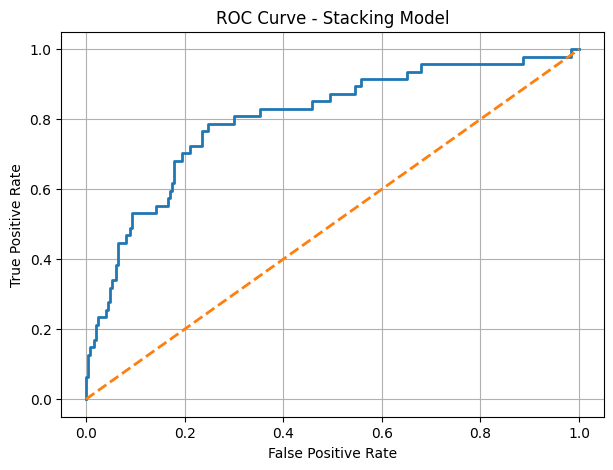

✅ Stacking model trained and saved as 'stacking_clf.pkl'
      EmployeeNumber                JobRole              Department  \
0                  1        Sales Executive                   Sales   
14                19  Laboratory Technician  Research & Development   
21                27   Sales Representative                   Sales   
26                33     Research Scientist  Research & Development   
33                42   Sales Representative                   Sales   
...              ...                    ...                     ...   
1396            1968        Sales Executive                   Sales   
1438            2023   Sales Representative                   Sales   
1444            2032  Laboratory Technician  Research & Development   
1452            2044        Sales Executive                   Sales   
1461            2055        Sales Executive                   Sales   

      Attrition_Risk                               Retention_Suggestion  
0           0.85

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import joblib

# Load dataset only if not already loaded
if 'df' not in globals():
    df = pd.read_csv('emp.csv')

# Quick sanity check
df.head()

# Encode categorical variables
df_encoded = df.copy()
label_encoders = {}
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Feature Engineering
df_encoded['Satisfaction_Score'] = (
    df_encoded['EnvironmentSatisfaction'] +
    df_encoded['JobSatisfaction'] +
    df_encoded['RelationshipSatisfaction'] +
    df_encoded['WorkLifeBalance']
) / 4

df_encoded['Experience_Ratio'] = df_encoded['YearsAtCompany'] / (df_encoded['TotalWorkingYears'] + 1)
df_encoded['Years_Since_Promotion'] = df_encoded['YearsAtCompany'] - df_encoded['YearsSinceLastPromotion']
df_encoded['Income_by_Age'] = df_encoded['MonthlyIncome'] / (df_encoded['Age'] + 1)
df_encoded['Work_Stress'] = df_encoded['OverTime'] * (1 - df_encoded['WorkLifeBalance'] / 4)
df_encoded['Job_Stability_Index'] = df_encoded['YearsInCurrentRole'] / (df_encoded['NumCompaniesWorked'] + 1)

df_encoded['Income_Percentile_by_Role'] = df_encoded.groupby('JobRole')['MonthlyIncome'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1)
)
df_encoded['Promotion_Velocity'] = df_encoded['YearsAtCompany'] / (df_encoded['YearsSinceLastPromotion'] + 1)
df_encoded['Training_per_Year'] = df_encoded['TrainingTimesLastYear'] / (df_encoded['TotalWorkingYears'] + 1)
df_encoded['Stock_Income_Ratio'] = df_encoded['StockOptionLevel'] / (df_encoded['MonthlyIncome'] / 10000 + 1)
df_encoded['Age_Experience_Gap'] = np.abs(df_encoded['Age'] - df_encoded['TotalWorkingYears'] - 18)
df_encoded['Department_Seniority'] = df_encoded.groupby('Department')['JobLevel'].transform('rank', pct=True)
df_encoded['Travel_Satisfaction_Impact'] = df_encoded['BusinessTravel'] * (1 - df_encoded['WorkLifeBalance'] / 4)
df_encoded['Overtime_Tenure_Ratio'] = df_encoded['OverTime'] / (df_encoded['YearsInCurrentRole'] + 1)
df_encoded['Career_Progression'] = (df_encoded['JobLevel'] / (df_encoded['YearsAtCompany'] + 1)) * 100
df_encoded['Comp_Satisfaction_Gap'] = (df_encoded['MonthlyIncome'] / 10000) - df_encoded['JobSatisfaction']

# Prepare features and target
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base models for stacking
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_base = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_base), ('rf', rf_base)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Train model
stacking_clf.fit(X_train_scaled, y_train)

# ==============================
# ✅ EVALUATION METRICS (ADDED)
# ==============================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Predictions on test set
y_pred = stacking_clf.predict(X_test_scaled)
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

print("\n==============================")
print("📌 MODEL EVALUATION RESULTS")
print("==============================")

print(f"✅ Accuracy   : {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ Precision  : {precision_score(y_test, y_pred):.4f}")
print(f"✅ Recall     : {recall_score(y_test, y_pred):.4f}")
print(f"✅ F1-Score   : {f1_score(y_test, y_pred):.4f}")
print(f"✅ ROC-AUC    : {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Model")
plt.grid(True)
plt.show()




# Save model
joblib.dump(stacking_clf, 'stacking_clf.pkl')
print("✅ Stacking model trained and saved as 'stacking_clf.pkl'")

# Predict attrition probability for all employees
X_full_scaled = scaler.transform(X)
attrition_probs = stacking_clf.predict_proba(X_full_scaled)[:, 1]
df_encoded['Attrition_Risk'] = attrition_probs

# Identify critical employees
def is_critical(row):
    return (
        (row['JobLevel'] >= 4) or
        (row['PerformanceRating'] >= 4) or
        (row['YearsAtCompany'] >= 10) or
        (row['Department'] in [
            label_encoders['Department'].transform(['Research & Development'])[0],
            label_encoders['Department'].transform(['Sales'])[0]
        ])
    )

df_encoded['Is_Critical'] = df_encoded.apply(is_critical, axis=1)

critical_employees = df_encoded[
    (df_encoded['Attrition_Risk'] > 0.6) &
    (df_encoded['Is_Critical'])
].copy()

# Generate retention suggestions
def retention_suggestion(row):
    suggestions = []
    if row['JobSatisfaction'] <= 2:
        suggestions.append("Assign mentorship, review job design")
    if row['MonthlyIncome'] < df_encoded['MonthlyIncome'].mean():
        suggestions.append("Review compensation, offer retention bonus")
    if row['YearsSinceLastPromotion'] > 3:
        suggestions.append("Consider career advancement plan")
    if row['OverTime'] == 1:
        suggestions.append("Offer flexible scheduling, workload relief")
    return "; ".join(suggestions) if suggestions else "Regular check-in"

critical_employees['Retention_Suggestion'] = critical_employees.apply(retention_suggestion, axis=1)

# Prepare final output
output_df = df_encoded.loc[
    critical_employees.index,
    ['EmployeeNumber', 'JobRole', 'Department', 'Attrition_Risk']
]
output_df['Retention_Suggestion'] = critical_employees['Retention_Suggestion']

# Convert encoded columns back to original labels
output_df['JobRole'] = label_encoders['JobRole'].inverse_transform(output_df['JobRole'])
output_df['Department'] = label_encoders['Department'].inverse_transform(output_df['Department'])

# Display critical employees with retention suggestions
print(output_df[['EmployeeNumber', 'JobRole', 'Department', 'Attrition_Risk', 'Retention_Suggestion']])

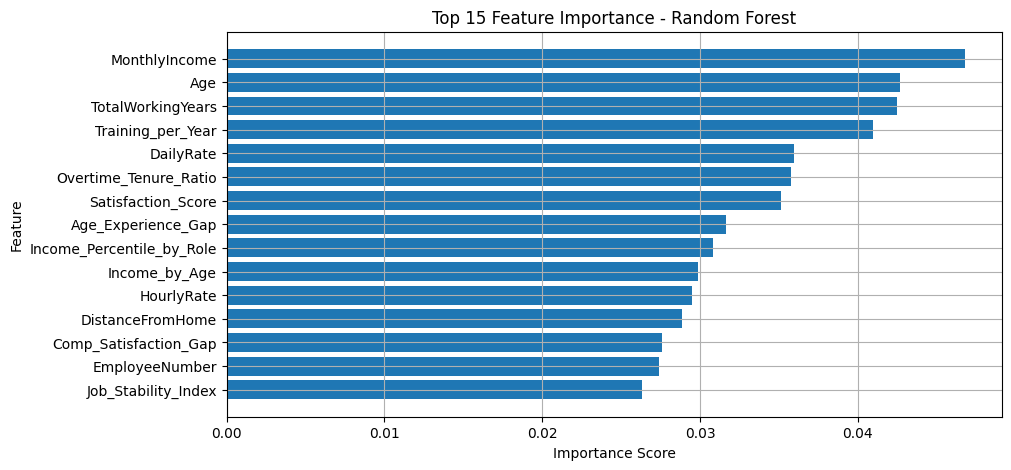

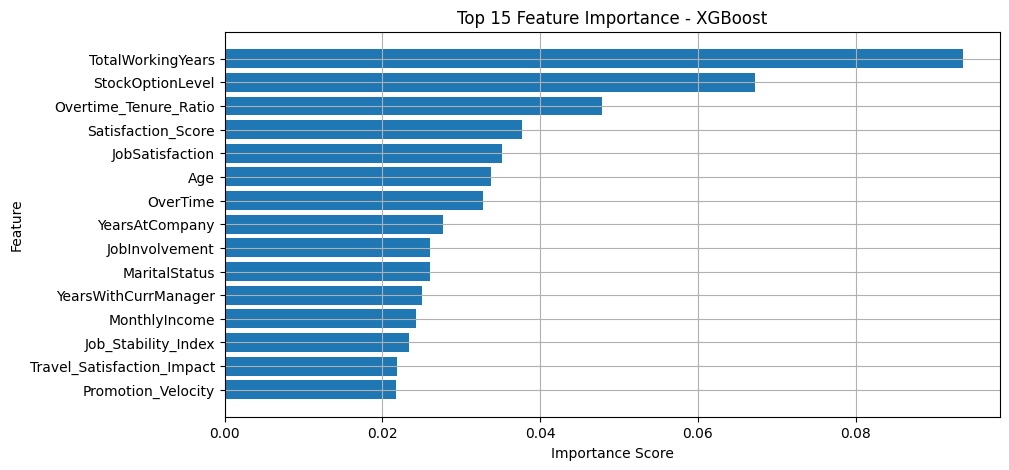

In [ ]:
# ==============================
# 📌 FEATURE IMPORTANCE (RF + XGB)
# ==============================

feature_names = X.columns

# Train RF and XGB separately (for feature importance)
rf_base.fit(X_train_scaled, y_train)
xgb_base.fit(X_train_scaled, y_train)

# ---- Random Forest Feature Importance ----
rf_importance = rf_base.feature_importances_
rf_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_importance
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10, 5))
plt.barh(rf_imp_df["Feature"], rf_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


# ---- XGBoost Feature Importance ----
xgb_importance = xgb_base.feature_importances_
xgb_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb_importance
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10, 5))
plt.barh(xgb_imp_df["Feature"], xgb_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


🔍 Generating SHAP explanations (XGBoost)...


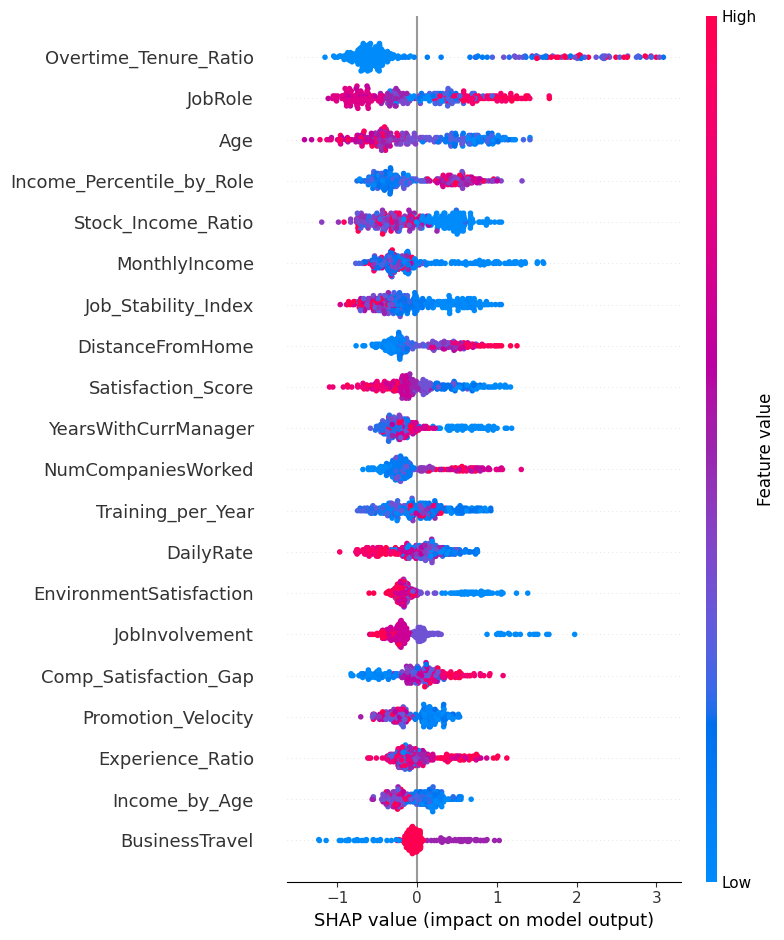

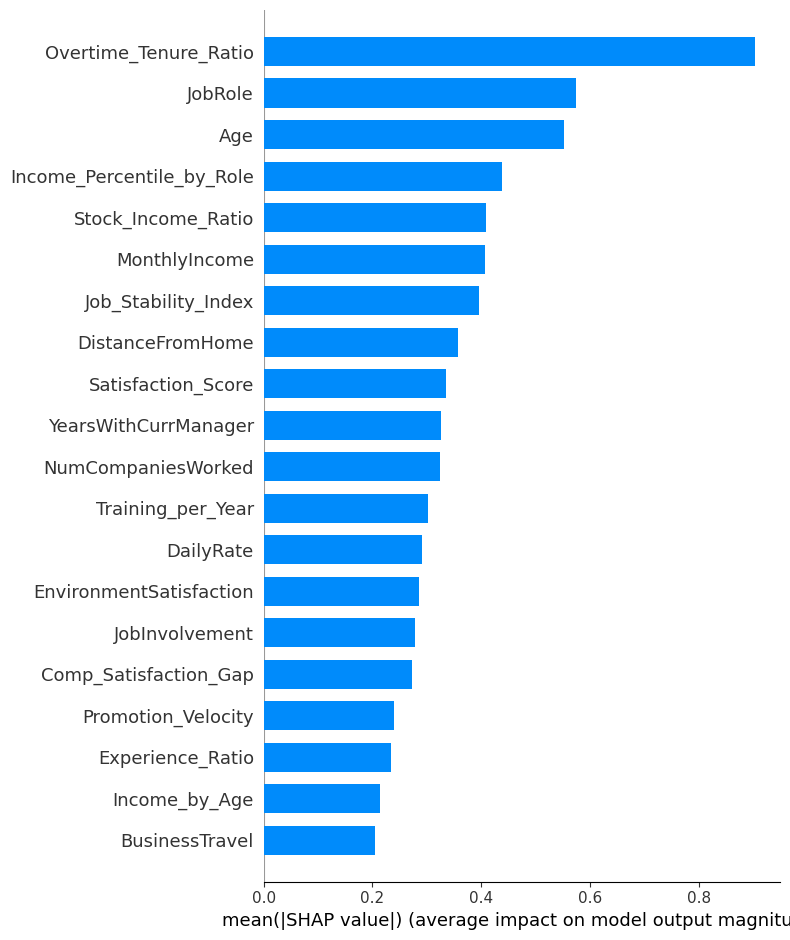

In [ ]:
import shap
# ==============================
# 🔍 SHAP EXPLAINABILITY (XGBoost)
# ==============================

print("\n🔍 Generating SHAP explanations (XGBoost)...")

# SHAP needs data in same format used for training
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(xgb_base, X_test_scaled_df)

# Compute SHAP values
shap_values = explainer(X_test_scaled_df)

# 1) SHAP Summary Plot (Global Importance)
shap.summary_plot(shap_values, X_test_scaled_df, show=True)

# 2) SHAP Bar Plot (Global Importance)
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=True)